In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pickle

In [75]:
#models
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn import metrics

#imbalance oversampling
from collections import Counter
from imblearn.over_sampling import SMOTE

In [77]:
# output setting
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)

In [78]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Import datasets

In [79]:
#import label
y_dt = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/postclick/data/orange_small_train_appetency.labels',sep = '\t', header = None)

In [80]:
# set lable name as 'y'
y_dt.columns = ['y']

In [81]:
# imbalance classes
y_dt.y.value_counts(dropna = False, normalize = True)

-1    0.9822
 1    0.0178
Name: y, dtype: float64

([<matplotlib.patches.Wedge at 0x7f510e22ca50>,
 [Text(-1.0982805562606, 0.061480238612967746, '-1'),
  Text(1.098280561297267, -0.06148014863807711, '1')],
 [Text(-0.5990621215966908, 0.03353467560707331, '98%'),
  Text(0.5990621243439638, -0.03353462652986024, '2%')])

Text(0.5, 1.0, 'outcome')

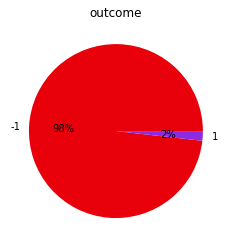

In [82]:
#define pie data
freq = y_dt.y.value_counts(dropna = False)
labels = ['-1', '1']

#define Seaborn color palette to use
colors = sns.color_palette('bright')[3:5]

#create pie chart
plt.pie(freq, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('outcome')
plt.show()

In [83]:
# import features(predictors)
x_dt = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/postclick/data/orange_small_train.data',sep = '\t')

In [84]:
x_dt.shape

(50000, 230)

# Feature exploration and selection

Categorical variables selection rules:
1. Exclude variabales with >40% missing data(eg. Var215)
2. Exclude variables with only one level(eg. Var215)
3. Only include variables with <= 5 levels variables(eg. Var198,exclued)
4. Exclude variables if its most frequency levels > 95% (eg.Var196)

Numeric variables selection rules:
1. Exclude variables with >40% missing data

In [85]:
#: total rows of dataset
n = x_dt.shape[0]

In [86]:
# checking missing rate for each variables(230 total)
Not_missing_rate = ((n - x_dt.isnull().sum())/n)

In [87]:
Not_missing_rate.sort_values()

Var230    0.00000
Var52     0.00000
Var48     0.00000
Var79     0.00000
Var42     0.00000
Var39     0.00000
Var32     0.00000
Var31     0.00000
Var141    0.00000
Var20     0.00000
Var167    0.00000
Var15     0.00000
Var55     0.00000
Var175    0.00000
Var209    0.00000
Var169    0.00000
Var185    0.00000
Var8      0.00000
Var118    0.00342
Var92     0.00342
Var64     0.00476
Var190    0.00666
Var45     0.00688
Var102    0.00902
Var98     0.01116
Var12     0.01116
Var62     0.01116
Var178    0.01292
Var89     0.01292
Var56     0.01292
Var66     0.01388
Var136    0.01388
Var63     0.01388
Var215    0.01388
Var156    0.01388
Var58     0.01404
Var187    0.01404
Var77     0.01404
Var86     0.01404
Var168    0.01404
Var186    0.01404
Var90     0.01404
Var108    0.01404
Var110    0.01404
Var116    0.01404
Var121    0.01404
Var129    0.01404
Var131    0.01404
Var137    0.01404
Var180    0.01404
Var142    0.01404
Var154    0.01404
Var87     0.01404
Var100    0.01404
Var1      0.01404
Var53     

In [88]:
# feature names for prediction
# Exclude variables with >40% data missing (eg. Var207) 
predictor_vars = Not_missing_rate[Not_missing_rate > 0.6].index

In [89]:
# (230-67)/230 = 163/230= 71% variables with have >40% missing data, which are removed from prediction
predictor_vars.size

67

In [90]:
# the dataset for predictive modelling
xs = x_dt[predictor_vars]

In [91]:
# categorical vars names
cal_vars = xs.columns[xs.dtypes == 'object']

In [92]:
cal_vars.size

28

In [93]:
#numeric vars names
num_vars = xs.columns[xs.dtypes != 'object']

In [94]:
num_vars.size

39

In [140]:
# check categorical variables distributions
# remove uninformative categorical variables due to the large number of levels with small frequency
# or only have one level
# I only use categorical vars with <=5 levels as predictors
# And the level proportions should be < 95% 
cal_vars_2 = []
for col in xs[cal_vars]:
  if (xs[col].value_counts().size <= 5 and xs[col].value_counts().size > 1 and xs[col].value_counts()[0]/n < 0.95):
    xs[col].value_counts(dropna = False)/n
    print('\n')
    cal_vars_2.append(col)


9_Y1    0.90466
HLqf    0.06336
F3hy    0.02902
NaN     0.00286
dgxZ    0.00008
pybr    0.00002
Name: Var203, dtype: float64

VpdQ       0.63924
09_Q       0.23148
sJzTlal    0.09060
NaN        0.03868
Name: Var205, dtype: float64

kIsH    0.92044
sBgB    0.07670
NaN     0.00286
Name: Var208, dtype: float64

L84s    0.80598
Mtgm    0.19402
Name: Var211, dtype: float64

cJvF    0.50638
UYBR    0.47956
NaN     0.01406
Name: Var218, dtype: float64

LM8l689qOp    0.73216
jySVZNlOJy    0.11990
NaN           0.10422
M_8D          0.04044
bCPvVye       0.00328
Name: Var223, dtype: float64

In [141]:
# final categorical variables for prediction
cal_vars_2

['Var203', 'Var205', 'Var208', 'Var211', 'Var218', 'Var223']

In [97]:
#check numeric variables' distributions 
xs[num_vars].describe()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var57,Var65,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var109,Var112,Var113,Var119,Var123,Var125,Var126,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181
count,44471.000000,44461.000000,44461.000000,44471.000000,44991.000000,42770.000000,44991.000000,44989.000000,44991.000000,4.499100e+04,44991.000000,50000.000000,44461.000000,50000.00000,44461.000000,4.499100e+04,44991.000000,4.447100e+04,44991.000000,44991.000000,42770.000000,44991.000000,5.000000e+04,44471.000000,44991.000000,4.446100e+04,36080.000000,44991.000000,4.499100e+04,4.499100e+04,44461.000000,44991.000000,44471.000000,4.277000e+04,4.499100e+04,44991.000000,4.499100e+04,44991.000000,44991.000000
mean,1326.437116,6.809496,1249.688401,234.518225,290.245382,4.507926,96.827010,224.507669,0.716810,2.579107e+06,0.166833,3.512311,14.868896,66.64108,103.658127,1.490154e+06,0.534707,1.030841e+05,20.023560,8.461026,60.888660,66.221066,-1.532786e+05,916.112185,60.188038,2.788763e+04,-0.553880,3.524616,2.273572e+06,4.373404e+05,1381.259643,0.058012,11.727665,2.949208e+05,6.181967e+06,38.803005,4.860780e+05,0.006846,0.611456
std,2685.693668,6.326053,2794.954874,565.560147,704.489990,9.928819,214.318283,98.520240,2.996007,3.010076e+06,1.629344,2.025882,10.134441,52.85917,766.711978,1.853693e+06,2.135359,1.062721e+05,88.129462,20.620485,141.249202,157.637671,7.613730e+05,2165.433155,221.551302,9.012838e+04,22.532095,9.994878,2.438600e+06,6.043415e+05,3990.510522,0.643061,11.720288,6.568946e+05,4.348926e+06,99.497149,8.488638e+05,0.132503,2.495681
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-66.880000,0.000000,0.000000e+00,0.000000,0.000214,9.000000,4.00000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-9.803600e+06,0.000000,0.000000,0.000000e+00,-32.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,518.000000,0.000000,0.000000,112.000000,135.000000,0.000000,16.000000,166.560000,0.000000,7.794000e+03,0.000000,1.743164,9.000000,24.00000,0.000000,8.936000e+04,0.000000,1.635696e+04,0.000000,0.000000,24.000000,16.000000,-1.827148e+05,425.000000,6.000000,2.340000e+02,-20.000000,0.000000,2.168075e+05,2.980800e+04,0.000000,0.000000,0.000000,0.000000e+00,1.232346e+06,10.000000,0.000000e+00,0.000000,0.000000
50%,861.000000,7.000000,232.000000,144.000000,180.000000,2.000000,48.000000,220.080000,0.000000,1.290246e+06,0.000000,3.514741,9.000000,52.00000,7.000000,8.820000e+05,0.000000,7.352341e+04,10.000000,4.000000,32.000000,40.000000,2.961542e+04,560.000000,30.000000,6.471000e+03,4.000000,0.000000,1.479810e+06,2.089280e+05,220.000000,0.000000,9.000000,5.189800e+04,8.131560e+06,22.000000,1.346220e+05,0.000000,0.000000
75%,1428.000000,7.000000,1604.000000,228.000000,285.000000,6.000000,112.000000,266.400000,0.000000,4.570944e+06,0.000000,5.264741,18.000000,102.00000,84.000000,2.309884e+06,0.000000,1.819770e+05,25.000000,10.000000,56.000000,72.000000,1.474875e+05,895.000000,72.000000,3.161700e+04,10.000000,0.000000,3.604725e+06,6.148840e+05,1350.000000,0.000000,18.000000,4.121128e+05,1.037338e+07,42.000000,6.159000e+05,0.000000,0.000000
max,131761.000000,140.000000,197872.000000,36272.000000,45340.000000,494.000000,13168.000000,5158.560000,110.000000,1.884690e+07,135.000000,7.000000,180.000000,264.00000,142156.000000,1.935360e+07,39.000000,1.814403e+06,6335.000000,1178.000000,7456.000000,10352.000000,9.932480e+06,105060.000000,13086.000000,5.436045e+06,68.000000,184.000000,1.500990e+07,5.735340e+06,520545.000000,18.000000,81.000000,1.693440e+07,1.390780e+07,4862.000000,1.451520e+07,6.000000,49.000000


In [98]:
# predictors col names
feature_cols = cal_vars_2 + num_vars.values.tolist()

In [99]:
# move some numeric vars with >75% zero values
#feature_cols = [col for col in feature_cols if col not in (['Var173','Var181','Var35','Var44','Var78','Var143'])]

# Tune models

In [100]:
## split train and test data sets
X_train, X_test, y_train, y_test = train_test_split(xs[feature_cols].to_numpy(), y_dt[['y']].to_numpy(), test_size = 0.3, random_state=0)

In [101]:
#pipeline: proprocessing numeric and categorical var

numeric_transformer = Pipeline(
    steps=[('scaler', StandardScaler())
           ]
)

categorical_transformer = Pipeline(
    steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
)

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, np.arange(len(cal_vars_2))),
                  ('num', numeric_transformer, np.arange(len(cal_vars_2),len(feature_cols),1))
                 ]
)

In [102]:
# weighted imbalance data 
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train.ravel()
)

In [103]:
# initialize xgboost classifier
xgb_estimator = XGBClassifier(learning_rate =0.1, n_estimators=500, max_depth=8,
              min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,sample_weight=sample_weights,
              objective= 'binary:logistic', nthread=4, scale_pos_weight=90, seed=27)

In [104]:
# built pipeline
estimator_xgb = Pipeline(steps = [('preprocessor', preprocessor),
                      ('classifier', xgb_estimator)])

In [105]:
# define grid search parameters
n_folds = 3
param_grid = dict(classifier__learning_rate = [0.001], 
                  classifier__n_estimators = [1000],
                  classifier__max_depth = [15],
                  classifier__subsample = [0.7],
                  classifier__colsample_bytree = [0.8],
                  classifier__gamma = [0.1],
                  classifier__min_child_weight = [5],
                  classifier__scale_pos_weight = [70,90]                  
                 )
grid_xgb = GridSearchCV(estimator_xgb, param_grid = param_grid, cv = n_folds, scoring= 'f1')

In [106]:
# train model with grid search, cv
grid_xgb_mdl = grid_xgb.fit(X_train, y_train.ravel())

In [107]:
grid_xgb_mdl.best_params_

{'classifier__colsample_bytree': 0.8,
 'classifier__gamma': 0.1,
 'classifier__learning_rate': 0.001,
 'classifier__max_depth': 15,
 'classifier__min_child_weight': 5,
 'classifier__n_estimators': 1000,
 'classifier__scale_pos_weight': 90,
 'classifier__subsample': 0.7}

In [133]:
# save model
#filename = 'grid_xgb_mdl.sav'
#pickle.dump(grid_xgb_mdl, open(filename, 'wb'))

# reload model
#grid_xgb_mdl = pickle.load(open(filename, 'rb'))

# model evaluation
For this imbalance classification question, we choose Recall,F1 score as the model selection metric

In [135]:
y_pred = grid_xgb_mdl.predict(X_test)

In [136]:
metrics.roc_auc_score(y_test,y_pred)

0.5953302957566203

In [137]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.99      0.92      0.95     14729
           1       0.06      0.27      0.10       271

    accuracy                           0.91     15000
   macro avg       0.52      0.60      0.53     15000
weighted avg       0.97      0.91      0.94     15000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 0.98, 'Confusion Matrix')

Confusion matrix:
[[13624  1105]
 [  199    72]]


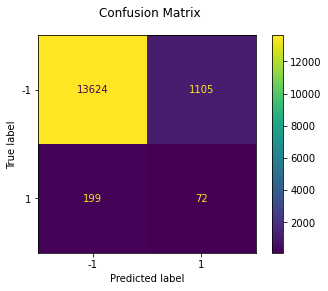

In [139]:
#metrics.confusion_matrix(m_y_test, m_y_pred)
disp = metrics.plot_confusion_matrix(grid_xgb_mdl, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

# Summary:

*   This is a binary imbalance classification problem
*   Xgboost tree classifier is a powerful and popular classifier. Its built-in algorithms deal with missing data or sparse values of features issues and weighted classes.

*   After tuning the hyper parameters with gird search and cross validation, the best model with roc auc = 0.6, a fair model.
* For further improve model ability to identify minority class, could explor resampling method, try other classifiers(Random Forest, SVM...) and also further refine the feature selection process.


